# Visualizing Data with Differential Privacy: A Comparison between Python and AGENT

## Introduction
The importance of maintaining privacy in data analysis cannot be overstated, especially when dealing with sensitive information. Differential privacy provides a framework to aggregate data insights while safeguarding individual data points. The Antigranular Enterprise (AGENT) framework introduces a novel approach to integrating differential privacy directly into data analysis and visualization workflows. This document showcases a comparative analysis between traditional Python-based data visualization techniques and those offered by AGENT.

## Setup and Initial Connection
To begin, the `antigranular_enterprise` library is installed and imported along with other necessary data visualization libraries such as seaborn, pandas, and matplotlib. The connection to AGENT is established using a provided API key, indicating a successful setup for differential privacy-enabled analysis.

In [ ]:
!pip install antigranular_enterprise -U 1> /dev/null 2> /dev/null
import antigranular_enterprise as ag
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# These details will be used going forward, you can have and toggle between multiple profiles
ag.load_config("https://api-agent.release.antigranular.com/config/client", profile='default')

session = ag.login(api_key="<api_key>")

Your request is pending approval. Please visit the following URL to approve the request: https://agent.release.antigranular.com
Request approved.
Connected to Antigranular server session id: dd1ba637-e1c1-4b5b-af38-09752388af0b
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server


## Data Loading and Preparation
The dataset used for this demonstration is the well-known diamond dataset, loaded via seaborn. This dataset serves as an excellent basis for both traditional and privacy-preserving data visualization.

In [ ]:
# Load the dataset
diamonds = sns.load_dataset('diamonds')

# Display the first few rows of the dataframe
print(diamonds.head())

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


## Implementing Differential Privacy with AGENT

The core of this demonstration lies in the utilization of AGENT's differential privacy capabilities. A `PrivateDataFrame` object is created from the diamonds dataset, specifying metadata for differential privacy controls. This setup enables the execution of data analysis tasks within a privacy-preserving environment.

In [ ]:
session.private_import(diamonds, "df")

dataframe cached to server, loading to kernel...
DataFrame loaded successfully to the kernel



In [ ]:
%%ag
import op_pandas as opd

pdf = opd.PrivateDataFrame(
    df,
    metadata = {
        "carat": (0.0, 5.1),
        "depth": (40, 80),
        "table": (2, 100),
        "price": (100, 20000),
        "x": (0, 11),
        "y": (0, 60),
        "x": (0, 35),
    },
    categorical_metadata = {
        "cut": ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'],
        "color": ['E', 'I', 'J', 'H', 'F', 'G', 'D'],
        "clarity": ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
    }
)

# Visualizing Data: Comparison between Python and AGENT

## Histograms

A basic yet powerful visualization, histograms of the price attribute of diamonds are created both traditionally and with differential privacy through AGENT. The comparison showcases how AGENT's privacy-preserving mechanisms impact the visualization outcome.

In [ ]:
%%ag
bins = pdf.hist(eps=0.1, column="price", bins = 50)

export(bins, "bins")

Setting up exported variable in local environment: bins


(0.0, 0.0005175174161898343)

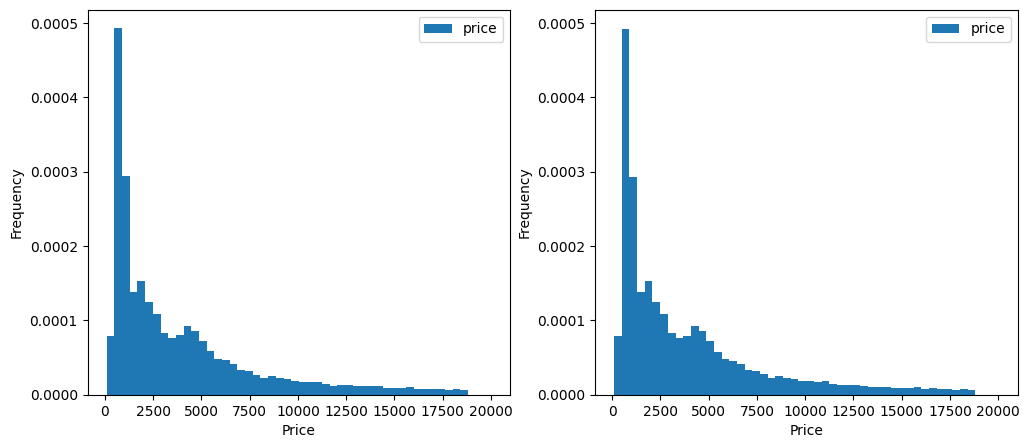

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# plotting the results from AGENT
ax1.bar(bins[1][:-1], bins[0]/(bins[0].sum() * np.diff(bins[1])), width=np.diff(bins[1]),  align='edge', label="price")
ax1.legend()
ax1.set_xlabel("Price")
ax1.set_ylabel("Frequency")

# plotting the true histogram
diamonds.plot.hist(column="price", bins = bins[1], ax=ax2, density=True)
ax2.set_xlabel("Price")
ax2.set_ylabel("Frequency")

ax2.set_ylim(ax1.get_ylim())

## 2D Histograms
Expanding on single-dimensional histograms, 2D histograms comparing carat and price offer a deeper insight into the dataset's structure, again contrasted between Python and AGENT's differential privacy approach.

In [ ]:
%%ag
bins = pdf.hist2d(eps=0.1, x="carat", y="price", bins = 50)

export(bins, "bins")

Setting up exported variable in local environment: bins


Text(0, 0.5, 'Price')

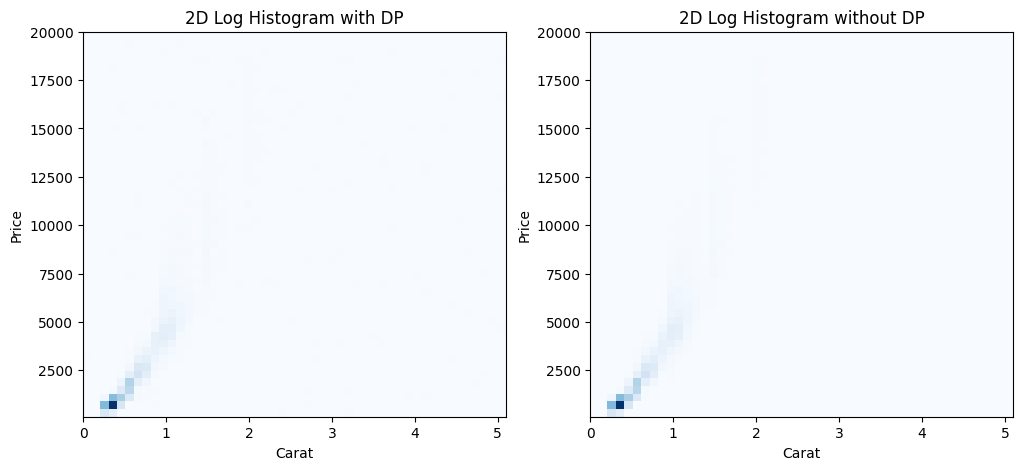

In [ ]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# plotting the results from AGENT
X, Y = np.meshgrid(bins[1], bins[2])
ax1.pcolormesh(X, Y, bins[0].T, cmap='Blues') # Note the transpose of hist to align axes
ax1.set_title('2D Log Histogram with DP')

# ploting the true results for comparisons
ax2.hist2d(diamonds['carat'], diamonds['price'], cmap='Blues',  bins=[X[0,:], Y[:,0]])
ax2.set_title('2D Log Histogram without DP')

ax1.set_xlabel("Carat")
ax1.set_ylabel("Price")

ax2.set_xlabel("Carat")
ax2.set_ylabel("Price")

''

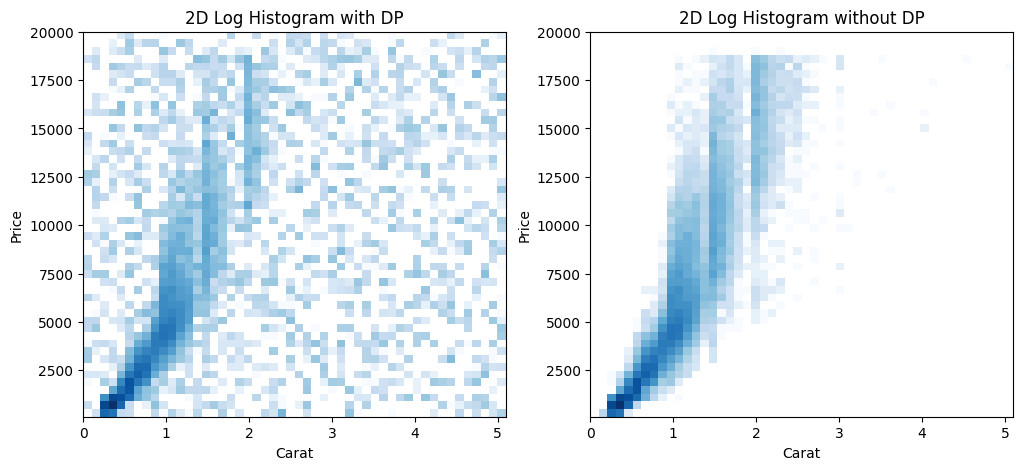

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# plotting the log results from AGENT
X, Y = np.meshgrid(bins[1], bins[2])
ax1.pcolormesh(X, Y, bins[0].T, cmap='Blues', norm=colors.LogNorm()) # Note the transpose of hist to align axes
ax1.set_title('2D Log Histogram with DP')

# ploting the true log results for comparisons
ax2.hist2d(diamonds['carat'], diamonds['price'], cmap='Blues',  norm=colors.LogNorm(), bins=[X[0,:], Y[:,0]])
ax2.set_title('2D Log Histogram without DP')

ax1.set_xlabel("Carat")
ax1.set_ylabel("Price")

ax2.set_xlabel("Carat")
ax2.set_ylabel("Price")

""

## Scatter Plots
Scatter plots provide a direct visual comparison of two variables. By utilizing AGENT to generate differentially private scatter plots, we can compare them against their non-private counterparts, demonstrating the balance between privacy and data utility.

In [ ]:
%%ag
import numpy as np
from op_pandas import PrivateDataFrame

#function to create differentially private X and Y distributions for scatterplots.
def dp_scatterplot(pdf: PrivateDataFrame, x: str, y: str, eps: int = 1, bins: int = 100):
    """
    A function to create differentially private X and Y distributions for scatterplots.

    Parameters
    ----------
    pdf : PrivateDataFrame
        The private dataframe containing the data.
    x : str
        The column name for the x-axis variable.
    y : str
        The column name for the y-axis variable.
    eps : int, optional
        The privacy parameter epsilon for differential privacy. Default is 1.
    bins : int, optional
        The number of bins to use for creating histograms. Default is 100.

    Returns
    -------
    tuple
        A tuple containing two arrays, representing the differentially private
        x and y distributions respectively.

    Example
    -------
    >>> x, y = dp_scatterplot(private_df, 'age', 'income', eps=0.5, bins=50)
    """
    # Generate a 2D grid bounded by the given distributions
    counts, x_edges, y_edges = pdf.hist2d(eps=eps, x=x, y=y, bins=bins)

    # Create empty lists to store DP distributions
    xs = []
    ys = []

    # Apply uniform sampling for each cell in the grid
    # We uniformly sample new points bounded by the ranges of each cell
    # The number of new points in each cell is controlled by `counts` generated above
    for x in range(len(x_edges) - 1):
        for y in range(len(y_edges) - 1):
            # Define the ranges for the current cell
            low_x = x_edges[x]
            high_x = x_edges[x + 1]

            low_y = y_edges[y]
            high_y = y_edges[y + 1]

            # Extract the count for the current cell
            c = counts[x, y]

            # Clip the count based on the standard error of Laplace distribution
            # This is based on the fact that hist2d generates cell counts with...
            # ...noise drawn using the Laplace mechanism
            if c > 3 * (2**0.5) / eps:
                # Sample new points uniformly within each grid cell's range
                new_points_x = np.random.uniform(low=low_x, high=high_x, size=int(c))
                new_points_y = np.random.uniform(low=low_y, high=high_y, size=int(c))

                # Add the points to final distributions
                xs.extend(new_points_x)
                ys.extend(new_points_y)

    return xs, ys

col_names = ["carat", "depth"]
x, y = dp_scatterplot(pdf, x=col_names[0], y=col_names[1], eps=1, bins = 200)

export(x, "x")
export(y, "y")
export(col_names, "col_names")

Setting up exported variable in local environment: x
Setting up exported variable in local environment: y
Setting up exported variable in local environment: col_names


(41.2, 80.8)

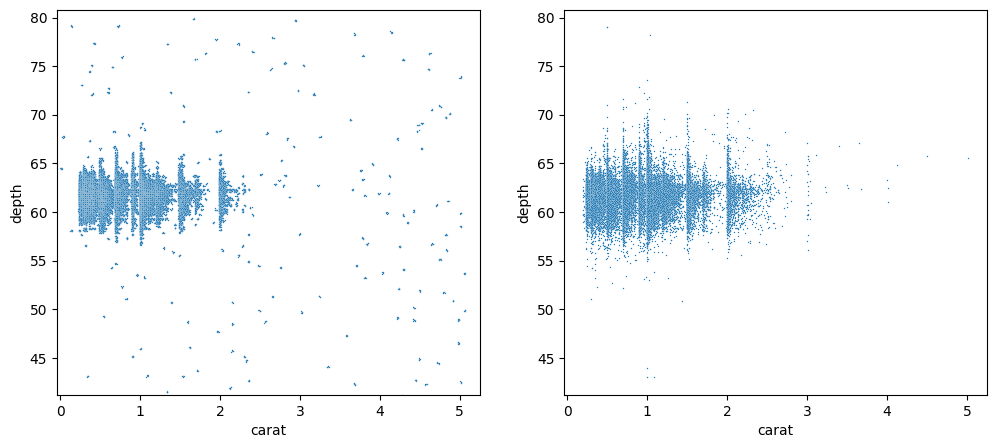

In [ ]:
from typing import List

# we want to compare DP vs Non-DP scatterplot for the same dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=pd.Series(x), y=pd.Series(y), s=1, ax=ax1)
ax1.set_xlabel(col_names[0])
ax1.set_ylabel(col_names[1])

# plotting the true scatter plot for comparison
sns.scatterplot(x=col_names[0], y=col_names[1], data=diamonds, s=1, ax=ax2)

# align the axis to make visual comparison easier
ax1.set_xlim(ax2.get_xlim())
ax1.set_ylim(ax2.get_ylim())

In [ ]:
%%ag
x, y = dp_scatterplot(pdf, x=col_names[0], y=col_names[1], eps=5, bins = 200)

export(x, "x")
export(y, "y")
export(col_names, "col_names")

Setting up exported variable in local environment: x
Setting up exported variable in local environment: y
Setting up exported variable in local environment: col_names


(41.2, 80.8)

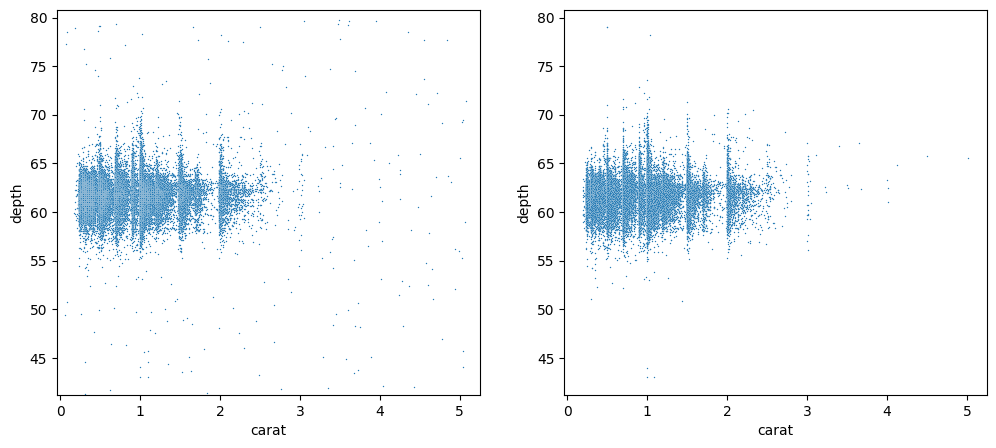

In [ ]:
# we want to compare DP vs Non-DP scatterplot for the same dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=pd.Series(x), y=pd.Series(y), s=1, ax=ax1)
ax1.set_xlabel(col_names[0])
ax1.set_ylabel(col_names[1])

# plotting the true scatter plot for comparison
sns.scatterplot(x=col_names[0], y=col_names[1], data=train_X, s=1, ax=ax2)

# align the axis to make visual comparison easier
ax1.set_xlim(ax2.get_xlim())
ax1.set_ylim(ax2.get_ylim())

## Box Plots
Box plots provide a concise yet informative summary of the distribution of data, highlighting the median, quartiles, and outliers. Utilizing the AGENT framework, we can generate differentially private box plots that aim to preserve the privacy of the underlying data while still providing a statistical overview.

In [ ]:
%%ag
from typing import List
from op_pandas import PrivateDataFrame


def dp_boxplot(pdf: PrivateDataFrame, col_names: List[str], eps=1):

    total_stats = []
    per_col_eps = eps / len(col_names)

    for col in col_names:

        # Calculate the 5-number summary
        five_num_summary = pdf[col].describe(eps=per_col_eps)

        # Calculate IQR
        IQR = five_num_summary['75%'] - five_num_summary['25%']

        # Extract the stats
        mean = five_num_summary['mean']
        med = five_num_summary['50%']
        q1 = five_num_summary['25%']
        q3 = five_num_summary['75%']
        minimum = five_num_summary['min']
        maximum = five_num_summary['max']

        # Calculate whisker lengths and fliers
        whislo = q1 - (1.5 * IQR)
        whishi = q3 + (1.5 * IQR)
        fliers = []

        if whislo < minimum:
            whislo = minimum
        else:
            fliers.append(minimum)

        if whishi > maximum:
            whishi = maximum
        else:
            fliers.append(maximum)

        # Define the stats
        stats = {
            "label": col,
            "mean": mean,
            "med": med,
            "q1": q1,
            "q3": q3,
            "whislo": whislo,
            "whishi": whishi,
            "fliers": fliers
        }

        total_stats.append(stats)

    return total_stats

cols = ['x', 'y', 'z']
variable_stats = dp_boxplot(pdf, col_names=cols, eps=0.5)

export(variable_stats, "stats")
export(cols, "col_names")

Setting up exported variable in local environment: stats
Setting up exported variable in local environment: col_names


(0.8756835709875508, 71.97006097639344)

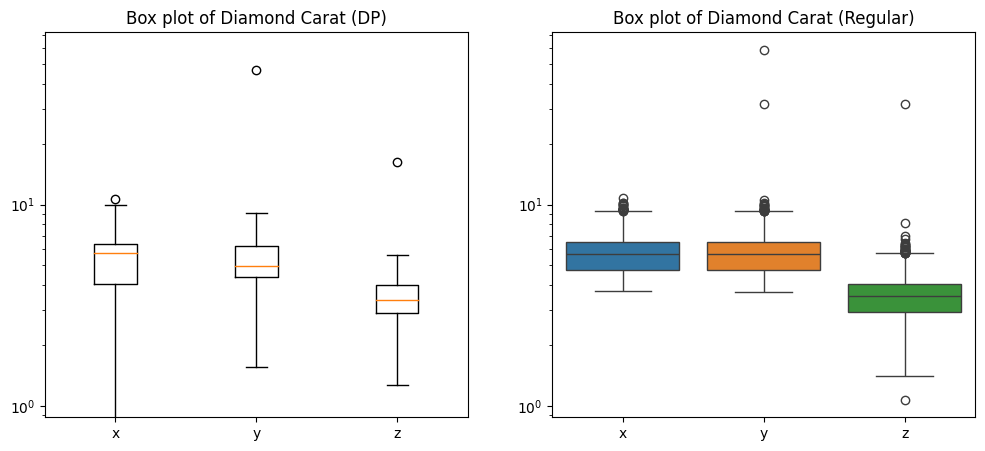

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


#ax1.bxp(**stats[0], showmeans=True, meanline=True, showfliers=True)

ax1.bxp(stats, showfliers=True)

# Adding title and labels
ax1.set_title('Box plot of Diamond Carat (DP)')
ax1.set_xticklabels([s['label'] for s in stats])

# we want to compare DP vs Non-DP scatterplot for the same dataset
sns.boxplot(data=diamonds[["x", "y", "z"]], ax=ax2)
ax2.set_title("Box plot of Diamond Carat (Regular)")

# logging the y-axis for visual clarity
ax2.set_yscale('log')
ax1.set_yscale('log')

# align the axis to make visual comparison easier
ax1.set_ylim(ax2.get_ylim())

## KDE Plots
Kernel Density Estimation (KDE) plots offer a smooth estimate of the distribution of a single variable, providing a visual representation that can be more informative than a histogram for understanding the shape of the data distribution. By applying differential privacy via AGENT, we can generate KDE plots that approximate the data's distribution while safeguarding privacy.

In [ ]:
%%ag
# function to create a differentially private X distribution for Kernel Density Estimation
def dp_kde(pdf: PrivateDataFrame, x: str, eps: int = 1, bins: int = 100):
    """
    A function to create a differentially private X distribution for Kernel Density Estimation.

    Parameters
    ----------
    pdf : PrivateDataFrame
        The private dataframe containing the data.
    x : str
        The column name for the x-axis variable.
    eps : int, optional
        The privacy parameter epsilon for differential privacy. Default is 1.
    bins : int, optional
        The number of bins to use for creating histograms. Default is 100.

    Returns
    -------
    array
        An array representing the differentially private x distribution.

    Example
    -------
    >>> x = dp_kde(private_df, 'age', eps=0.5, bins=50)
    """
    # create a 1D histogram grid bounded by the given distribution
    counts, x_edges = pdf.hist(eps=eps, column=x, bins=bins)

    # Create an empty list to store DP distribution
    xs = []

    # Apply uniform sampling for each bin in the histogram
    # We uniformly sample new points bounded by the ranges of each bin
    # The number of new points in each bin is controlled by `counts` generated above
    for x in range(len(x_edges) - 1):
        # Define the ranges for the current bin
        low_x = x_edges[x]
        high_x = x_edges[x + 1]

        # Extract the count for the current bin
        c = counts[x]

        # Sample new points uniformly within each bin's range
        new_points_x = np.random.uniform(low=low_x, high=high_x, size=int(c))

        # Add the points to final distribution
        xs.extend(new_points_x)
    return xs

col_name = "carat"
xs = dp_kde(pdf, x=col_name, eps = 0.1)

export(xs, "x")
export(col_name, "col_name")

Setting up exported variable in local environment: x
Setting up exported variable in local environment: col_name


<Axes: xlabel='carat', ylabel='Density'>

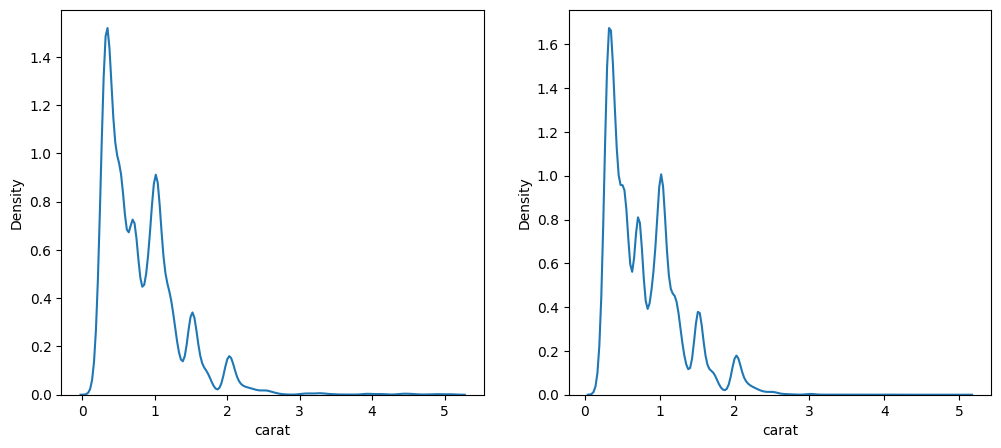

In [ ]:
# we want to compare DP vs Non-DP scatterplot for the same dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(x=pd.Series(x), ax = ax1)
ax1.set_xlabel(col_name)

# plot the true kde for visual comparison
sns.kdeplot(x=col_name, data=diamonds, ax = ax2)

# Conclusion
Through this comparative analysis, it is evident that the Antigranular Enterprise (AGENT) framework provides a robust solution for incorporating differential privacy into data visualization workflows. While there are observable differences in the visualizations produced under differential privacy constraints, AGENT successfully balances the trade-off between data privacy and utility.